In [1]:
import os, sys, time
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import mvpa2.suite as mvpa2
import itertools

from collections import Counter

import matplotlib.pylab as plt
%matplotlib inline

from scipy.spatial.distance import pdist,squareform

TR = 2.3

brands = np.array(['abercrombie-fitch','adobe','apple','axe','beats',
          'campina','dell','disney','durex','heineken','kelloggs',
          'microsoft','pampers','redbull'])

cat_names = ['work','sex','family','party']

sns.reset_orig()
plt.rc('font', family='Arial', size=16)
plt.rc('legend', fontsize='medium')
plt.rc('savefig', dpi=300)

In [2]:
def mean_corr(data):
    return np.tanh(np.mean(np.arctanh(data)))
def zscore(data):
    return (data-np.nanmean(data))/np.nanstd(data)

In [3]:
subjs = []

allsubjs = np.array(range(4,42))

for subj in allsubjs[allsubjs != 8]:
    if os.path.isfile('../survey/brand/S'+str(subj)+'_brand.csv'):
        subjs.append(subj) 

In [4]:
#method = 'native_indiv'
method = 'normalized_common'
r = 'picture_thresh2'
#r = 'picture_thresh2_entire_beta'

file_path = '../output/'+method+'/'+r.replace("picture","brand")

subj_brand_ds = {}
allsubjs = np.array(range(4,42))

for subj in allsubjs:
    subj_brand_ds[subj] = mvpa2.Dataset.from_hdf5(file_path+'/S'+str(subj)+'.h5py')

Single time-point

In [5]:
TR_type = 't012'
tp = 6

#TR_type = 't0'
#tp = 0

corr_dist = []
output = np.zeros((len(subjs)*14*4,5))

for i,subj in enumerate(subjs):
    behave = []
    neural = []

    brand_ds = subj_brand_ds[subj]

    survey_file = '../survey/brand/S'+str(subj)+'_brand.csv'
    survey = np.recfromcsv(survey_file,delimiter=',')

    for j,cn in enumerate(cat_names):
        behave.append(survey[:][cn])

        neural_score = []
        output_line = np.array(6)
        for b in range(14):
            n = np.mean(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                 (brand_ds.sa.timepoint >= tp) & \
                                 (brand_ds.sa.timepoint < tp+TR)]\
                                .sa[TR_type+'_'+cn+'_est'])
            neural_score.append(n)

        neural.append(neural_score)
        
        idx = i*4*14+j*14
        output[idx:idx+14,0] = subj
        output[idx:idx+14,1] = j
        output[idx:idx+14,2] = range(1,15)
        output[idx:idx+14,3] = behave[-1]          
        output[idx:idx+14,4] = neural[-1]
        
    neural = np.ravel(neural)
    behave = np.ravel(behave)
    corr_dist.append(sp.stats.pearsonr(neural,behave)[0])
print mean_corr(corr_dist)

f = open('brand_'+method+'_'+r+'_theme.csv','w')
f.write('subj,theme,brand,behave,neural\n')
for o in output:
    text_o = [str(oo) for oo in o]
    text_o[1] = cat_names[int(o[1])]#str(4-o[3])+'_'+cat_names[int(o[3])]
    f.write(','.join(text_o)+'\n') 
f.close()

0.0517027173578


Plot time series (c.f. Supplementary Analysis 11)

In [15]:
TR_type = 't0'

for tp in range(10):

    corr_dist = []

    for subj in subjs:
        behave = []
        neural = []
        
        brand_ds = subj_brand_ds[subj]

        survey_file = '../survey/brand/S'+str(subj)+'_brand.csv'
        survey = np.recfromcsv(survey_file,delimiter=',')

        for j,cn in enumerate(cat_names):
            behave.append(zscore(survey[:][cn]))

            neural_score = []
            output_line = np.array(6)
            for b in range(14):
                n = np.mean(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                                     (brand_ds.sa.timepoint >= tp) & \
                                     (brand_ds.sa.timepoint < tp+TR)]\
                                    .sa[TR_type+'_'+cn+'_est'])
                neural_score.append(n)

            neural.append(zscore(neural_score))

        neural = np.ravel(neural)
        behave = np.ravel(behave)
        corr_dist.append(sp.stats.pearsonr(neural,behave)[0])
    print mean_corr(corr_dist)

0.00565369592012
0.0662931424779
0.0863739058834
0.114736252379
0.140734481465
0.117987038572
0.116925500078
0.107915103186
0.102109796377
0.117827605835


Plot graph

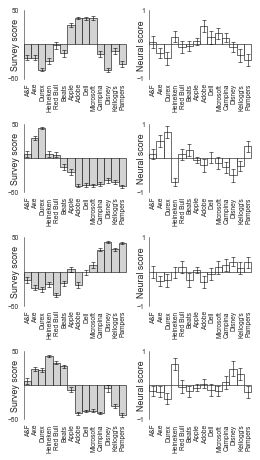

In [6]:
TR_type = 't012'
tp = 5.5

new_order = ['abercrombie-fitch','axe','durex',
             'heineken','redbull',             
             'beats','apple','adobe',
             'dell','microsoft',
             'campina','disney','kelloggs','pampers']

new_names = ['A&F','Axe','Durex',
             'Heineken','Red Bull',             
             'Beats','Apple','Adobe',
             'Dell','Microsoft',
             'Campina','Disney','Kellogg\'s','Pampers']

sns.set_style('white')
order_no = np.ravel([np.where(brands == new_order[i]) for i in range(len(new_order))])
plt.rc('font', family='Arial',size=8)
plt.rc('axes', labelsize='medium')
plt.rc('lines', linewidth=0.1)

behave_score = np.zeros((4,len(subjs),14)) * np.nan
neural_score = np.zeros((4,len(subjs),14)) * np.nan

subj_score = []

for i,subj in enumerate(subjs):
    
    brand_ds = subj_brand_ds[subj]
    
    survey_file = '../survey/brand/S'+str(subj)+'_brand.csv'
    survey = np.recfromcsv(survey_file,delimiter=',')
            
    for j,cn in enumerate(cat_names):
        for b in range(14):
            behave_score[j,i,b] = survey[b][cn]
            neural_score[j,i,b] = np.mean(brand_ds[(brand_ds.sa.brand == brands[b]) & \
                    (brand_ds.sa.timepoint >= tp) & \
                    (brand_ds.sa.timepoint < tp+TR)].sa[TR_type+'_'+cn+'_est'])

#for j,cn in enumerate(cat_names):
#    neural_score[j,:,:] = zscore(neural_score[j,:,:]) 
for i,subj in enumerate(subjs):
    for j,cn in enumerate(cat_names):
        neural_score[j,i,:] = zscore(neural_score[j,i,:]) 
        
bscore = np.nanmean(behave_score,axis=1)[:,order_no]-50
nscore = np.nanmean(neural_score,axis=1)[:,order_no]

bstd = sp.stats.sem(behave_score,axis=1)[:,order_no]
nstd = sp.stats.sem(neural_score,axis=1)[:,order_no]

fig, axe2 = plt.subplots(4, 2, figsize=(3.3,5.8))

for i in range(4):
    ind = np.arange(14)  # the x locations for the groups
    width = 1       # the width of the bars
    
    axe = axe2[i,:]
    
    ax = axe[0]
    
    rects1 = ax.bar(ind, bscore[i,:], width, color='lightgrey', ecolor='black', lw=0.5)
    err,_,_ = ax.errorbar(ind+0.5, bscore[i,:], bstd[i,:], capsize=1.5, capthick=0.5, ecolor='black', elinewidth=0.5)
    err.set_linestyle('None')
    
    ax.set_ylabel('Survey score',labelpad=-11)
    ax.set_xticks(ind+0.6)
    ax.set_yticks([-50,50])
    ax.xaxis.set_ticks_position('none') 
    ax.set_ylim([-50,50])
    ax.set_xlim([0,14.2])
    ax.tick_params('y',labelsize=6)

    ax.set_xticklabels(new_names, rotation=90, ha='center',size=6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.yaxis.set_ticks_position('left')

    ax = axe[1]    

    rects1 = ax.bar(ind, nscore[i,:], width, color='white', ecolor='black', lw=0.5)
    err,_,_ = ax.errorbar(ind+0.5, nscore[i,:], nstd[i,:], capsize=1.5, capthick=0.5, ecolor='black', elinewidth=0.5)
    err.set_linestyle('None')
        
    ax.set_ylabel('Neural score',labelpad=-8)
    ax.set_xticks(ind+0.6)
    ax.set_yticks([-1,1])
    ax.xaxis.set_ticks_position('none') 
    ax.set_ylim([-1,1])
    ax.set_xlim([0,14.2])
    ax.tick_params('y',labelsize=6)

    ax.set_xticklabels(new_names, rotation=90, ha='center',size=6)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.yaxis.set_ticks_position('left')
    
fig.tight_layout()
plt.savefig('brand_theme_score_pub.pdf',fmt='pdf')
plt.show()